In [1]:
import torch

# GPU를 사용할 수 있는지 확인
if torch.cuda.is_available():
    # 사용 가능한 GPU 디바이스 개수 확인
    num_gpu = torch.cuda.device_count()
    print(f"사용 가능한 GPU 수: {num_gpu}")

    # 현재 선택된 GPU 디바이스 확인
    current_gpu = torch.cuda.current_device()
    print(f"현재 선택된 GPU: {current_gpu}")

    # 사용 가능한 GPU 디바이스 목록 확인
    for i in range(num_gpu):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU를 사용할 수 없습니다.")


사용 가능한 GPU 수: 1
현재 선택된 GPU: 0
GPU 0: GeForce GTX 1060 6GB


c:\Users\user\anaconda3\envs\test_RL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install opencv-python
# !pip install gym[all,accept-rom-license]
# !pip install swig
# !pip install --upgrade pip setuptools wheel
# !pip install --upgrade gym
# !pip install tqdm
# !pip install gym[box2d]
# !pip install pyvirtualdisplay moviepy
# !pip install pandas

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
import pandas as pd
import time

In [6]:
# 설치된 모든 환경 출력
all_envs = list(gym.envs.registry.items())
print("설치된 환경 목록:", all_envs)

설치된 환경 목록: [('ALE/Adventure-v5', EnvSpec(id='ALE/Adventure-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure', version=5)), ('ALE/Adventure-ram-v5', EnvSpec(id='ALE/Adventure-ram-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'ram', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure-ram', version=5)), ('ALE/AirRaid-v5', EnvSpec(id='ALE

In [7]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# GPU 사용 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}, state : {state_size}, action : {action_size}")

cuda, state : 8, action : 4


In [9]:
#%% Policy network
class Qnet(nn.Module):

    def __init__(self, n_states, n_actions, n_hidden=64):
        super(Qnet, self).__init__()

        self.fc1 = nn.Linear(n_states, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        # self.fc3 = nn.Linear(n_hidden, n_hidden)
        # self.fc4 = nn.Linear(n_hidden, n_hidden)
        self.fc5 = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x  
    

In [12]:
class DQN:
    def __init__(self, n_states, n_actions, batch_size, lr, gamma, memory_size, learn_step, tau, device=None):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 가장 좋은 모델 저장을 위한 변수
        self.best_score = float('-inf')  # 초기화: 음수 무한대

        # 모델
        self.net_eval = Qnet(n_states, n_actions).to(device)
        self.net_target = Qnet(n_states, n_actions).to(device)
        self.optimizer = optim.AdamW(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # 메모리
        self.memory = ReplayBuffer(n_actions, memory_size, batch_size)
        self.counter = 0    # 업데이트 주기 카운터

        # 에피소드당 평균 보상을 기록할 리스트 초기화
        self.avg_score_hist = []

        # 총 보상을 기록할 리스트 초기화
        self.score_hist = []

    def sample_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.net_eval.eval()
        coin = random.random()

        with torch.no_grad():
            action_values_eval = self.net_eval(state)

        if coin < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            # Use net_eval for action selection and net_target for action evaluation
            action = np.argmax(self.net_target(state).cpu().data.numpy())

        self.net_eval.train()
        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.put(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)  # target, if terminal then y_j = rewards

        # 추가 부분
        actions = actions.to(torch.int64)
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.soft_update()

    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def train(self, env, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, chkpt=False):

        epsilon = eps_start
        start_time = time.time()
        epsilon = eps_start

        # Calculate decay factor based on the given eps_decay and number of episodes
        decay_factor = np.exp(np.log(eps_end / eps_start) / n_episodes)

        for idx_epi in tqdm(range(n_episodes), unit="ep", ascii=True):
            state = env.reset()[0]
            score = 0

            for idx_step in range(max_steps):
                action = self.sample_action(state, epsilon)
                next_state, reward, done, _, _ = env.step(action)
                self.save2memory(state, action, reward, next_state, done)
                state = next_state
                score += reward

                if done:
                    break

            experiences = self.memory.sample()
            self.learn(experiences)

            self.score_hist.append(score)
            score_avg = np.mean(self.score_hist[-100:])
            epsilon = max(eps_end, epsilon * decay_factor)  # Update epsilon using decay factor

            self.avg_score_hist.append(score_avg)

            if (idx_epi + 1) % 50 == 0:
                elapsed_time = time.time() - start_time  # 현재까지 걸린 시간 계산
                print(f"Episode {idx_epi + 1}, Score: {score:.3f}, Avg Score (last 100): {score_avg:.3f}, Epsilon: {epsilon:.3f}, Elapsed Time: {elapsed_time:.2f} seconds")

                if score > self.best_score:
                    self.best_score = score
                    print("====Saving the best model====")
                    torch.save(self.net_eval.state_dict(), 'best_model_DQN_2_layer.pth')

        if idx_epi == n_episodes - 1:
            print("\nDone!")

        self.save_scores_to_csv()

        return self.score_hist, self.avg_score_hist


    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def load_model(self, path):
        self.net_eval.load_state_dict(torch.load(path))
        self.net_eval.eval()

    def save_scores_to_csv(self, filename='scores_DQN_2_layer.csv'):
        df = pd.DataFrame({'Episode': np.arange(1, len(self.score_hist) + 1), 'Score': self.score_hist, 'Avg_Score': self.avg_score_hist})
        df.to_csv(filename, index=False)


In [13]:
class ReplayBuffer:
    def __init__(self, n_actions, memory_size, batch_size, device=None):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = collections.deque(maxlen=memory_size)

    def put(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.memory.append(transition)

    def sample(self):
        mini_batch = random.sample(self.memory, self.batch_size)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return (
            torch.tensor(s_lst, dtype=torch.float, device=self.device),
            torch.tensor(a_lst, device=self.device),
            torch.tensor(r_lst, dtype=torch.float, device=self.device),
            torch.tensor(s_prime_lst, dtype=torch.float, device=self.device),
            torch.tensor(done_mask_lst, dtype=torch.float, device=self.device)
        )

    def __len__(self):
        return len(self.memory)

In [14]:
def plot_score(scores, moving_avg_scores, save_path=None):
    plt.figure(figsize=(15, 4))
    
    # Plot Episode Score
    plt.plot(scores, label='Episode Score')
    
    # Plot Moving Average Score
    plt.plot(moving_avg_scores, label='Moving Average Score', color='r', linestyle='--')

    # Plot Overall Mean Score
    overall_mean_score = np.mean(scores)
    plt.axhline(y=overall_mean_score, color='g', linestyle='-.', label=f'Overall Mean Score: {overall_mean_score:.2f}')

    # Find and Plot Maximum Score
    max_score = np.max(scores)
    plt.scatter(np.argmax(scores), max_score, color='m', label=f'Max Score: {max_score:.2f}', marker='o', s=100)

    # Plot Standard Deviation
    std_dev_score = np.std(moving_avg_scores)
    plt.title(f"Scores Over Episodes - Standard Deviation: {std_dev_score:.2f}")

    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()

    # Save the plot to an image file if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    # Show the plot (either in a window or saved file)
    plt.show()



In [15]:
batch_size = 64
lr = 1e-3
episode = 10000
gamma = 0.999            # discount factor
memory_size = 10000     # max memory buffer size
learn_step = 5          # how often to learn
tau = 1e-4              # for soft update of target parameters
print(device)

cuda


In [16]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

agent = DQN(
    n_states=num_states,
    n_actions=num_actions,
    batch_size=batch_size,
    lr=lr,
    gamma=gamma,
    memory_size=memory_size,
    learn_step=learn_step,
    tau=tau,
    device=device
)

score_hist, avg_score_hist = agent.train(env, n_episodes=episode)


  1%|          | 51/10000 [00:04<16:19, 10.16ep/s]

Episode 50, Score: -442.913, Avg Score (last 100): -162.675, Epsilon: 0.977, Elapsed Time: 4.73 seconds
====Saving the best model====


  1%|1         | 101/10000 [00:10<22:56,  7.19ep/s]

Episode 100, Score: -177.915, Avg Score (last 100): -182.334, Epsilon: 0.955, Elapsed Time: 10.11 seconds
====Saving the best model====


  2%|1         | 150/10000 [00:16<16:27,  9.98ep/s]

Episode 150, Score: -272.833, Avg Score (last 100): -188.425, Epsilon: 0.933, Elapsed Time: 16.58 seconds


  2%|2         | 201/10000 [00:21<17:17,  9.44ep/s]

Episode 200, Score: -260.754, Avg Score (last 100): -192.623, Epsilon: 0.912, Elapsed Time: 21.72 seconds


  3%|2         | 251/10000 [00:27<17:59,  9.04ep/s]

Episode 250, Score: -42.551, Avg Score (last 100): -205.910, Epsilon: 0.891, Elapsed Time: 27.07 seconds
====Saving the best model====


  3%|3         | 301/10000 [00:32<16:21,  9.88ep/s]

Episode 300, Score: -37.977, Avg Score (last 100): -194.294, Epsilon: 0.871, Elapsed Time: 32.40 seconds
====Saving the best model====


  4%|3         | 351/10000 [00:38<18:45,  8.58ep/s]

Episode 350, Score: -68.138, Avg Score (last 100): -189.508, Epsilon: 0.851, Elapsed Time: 38.24 seconds


  4%|4         | 400/10000 [00:43<18:01,  8.88ep/s]

Episode 400, Score: -135.058, Avg Score (last 100): -187.758, Epsilon: 0.832, Elapsed Time: 43.89 seconds


  5%|4         | 451/10000 [00:50<18:49,  8.46ep/s]

Episode 450, Score: -84.332, Avg Score (last 100): -183.729, Epsilon: 0.813, Elapsed Time: 50.20 seconds


  5%|5         | 501/10000 [00:57<19:57,  7.93ep/s]

Episode 500, Score: -231.693, Avg Score (last 100): -172.651, Epsilon: 0.794, Elapsed Time: 57.07 seconds


  6%|5         | 551/10000 [01:03<20:03,  7.85ep/s]

Episode 550, Score: -81.662, Avg Score (last 100): -159.351, Epsilon: 0.776, Elapsed Time: 63.75 seconds


  6%|6         | 601/10000 [01:10<20:54,  7.49ep/s]

Episode 600, Score: -71.493, Avg Score (last 100): -146.415, Epsilon: 0.759, Elapsed Time: 70.39 seconds


  7%|6         | 651/10000 [01:18<19:18,  8.07ep/s]  

Episode 650, Score: -268.231, Avg Score (last 100): -141.358, Epsilon: 0.741, Elapsed Time: 78.67 seconds


  7%|7         | 701/10000 [01:25<23:44,  6.53ep/s]

Episode 700, Score: -139.544, Avg Score (last 100): -149.863, Epsilon: 0.724, Elapsed Time: 85.65 seconds


  8%|7         | 751/10000 [01:32<19:00,  8.11ep/s]

Episode 750, Score: -161.528, Avg Score (last 100): -140.893, Epsilon: 0.708, Elapsed Time: 92.84 seconds


  8%|8         | 801/10000 [01:41<24:41,  6.21ep/s]  

Episode 800, Score: -114.133, Avg Score (last 100): -131.002, Epsilon: 0.692, Elapsed Time: 101.76 seconds


  9%|8         | 851/10000 [01:51<22:41,  6.72ep/s]  

Episode 850, Score: -91.603, Avg Score (last 100): -133.227, Epsilon: 0.676, Elapsed Time: 111.00 seconds


  9%|9         | 901/10000 [01:59<23:54,  6.35ep/s]

Episode 900, Score: -274.892, Avg Score (last 100): -134.217, Epsilon: 0.661, Elapsed Time: 119.20 seconds


 10%|9         | 951/10000 [02:09<30:00,  5.03ep/s]  

Episode 950, Score: -163.675, Avg Score (last 100): -129.712, Epsilon: 0.646, Elapsed Time: 129.41 seconds


 10%|#         | 1000/10000 [02:18<26:56,  5.57ep/s]

Episode 1000, Score: -31.157, Avg Score (last 100): -124.177, Epsilon: 0.631, Elapsed Time: 138.56 seconds
====Saving the best model====


 10%|#         | 1050/10000 [02:28<23:14,  6.42ep/s]

Episode 1050, Score: -105.128, Avg Score (last 100): -124.175, Epsilon: 0.617, Elapsed Time: 148.33 seconds


 11%|#1        | 1100/10000 [02:37<30:28,  4.87ep/s]

Episode 1100, Score: -201.066, Avg Score (last 100): -120.440, Epsilon: 0.603, Elapsed Time: 157.20 seconds


 12%|#1        | 1151/10000 [02:48<25:18,  5.83ep/s]  

Episode 1150, Score: -179.030, Avg Score (last 100): -118.957, Epsilon: 0.589, Elapsed Time: 168.07 seconds


 12%|#2        | 1201/10000 [02:59<37:57,  3.86ep/s]  

Episode 1200, Score: 3.830, Avg Score (last 100): -119.240, Epsilon: 0.575, Elapsed Time: 179.55 seconds
====Saving the best model====


 12%|#2        | 1250/10000 [03:10<30:12,  4.83ep/s]  

Episode 1250, Score: -130.825, Avg Score (last 100): -111.712, Epsilon: 0.562, Elapsed Time: 190.67 seconds


 13%|#3        | 1301/10000 [03:27<32:35,  4.45ep/s]  

Episode 1300, Score: -142.931, Avg Score (last 100): -101.000, Epsilon: 0.550, Elapsed Time: 206.84 seconds


 14%|#3        | 1351/10000 [03:37<26:25,  5.46ep/s]

Episode 1350, Score: -62.766, Avg Score (last 100): -103.253, Epsilon: 0.537, Elapsed Time: 217.34 seconds


 14%|#4        | 1400/10000 [03:50<30:36,  4.68ep/s]  

Episode 1400, Score: -32.664, Avg Score (last 100): -106.520, Epsilon: 0.525, Elapsed Time: 230.02 seconds


 14%|#4        | 1450/10000 [04:03<32:15,  4.42ep/s]  

Episode 1450, Score: -168.486, Avg Score (last 100): -101.061, Epsilon: 0.513, Elapsed Time: 243.44 seconds


 15%|#5        | 1501/10000 [04:21<31:40,  4.47ep/s]  

Episode 1500, Score: -132.484, Avg Score (last 100): -90.264, Epsilon: 0.501, Elapsed Time: 261.76 seconds


 16%|#5        | 1550/10000 [04:37<32:14,  4.37ep/s]  

Episode 1550, Score: -240.332, Avg Score (last 100): -87.444, Epsilon: 0.490, Elapsed Time: 277.64 seconds


 16%|#6        | 1600/10000 [05:02<53:00,  2.64ep/s]  

Episode 1600, Score: -12.421, Avg Score (last 100): -70.226, Epsilon: 0.479, Elapsed Time: 302.32 seconds


 16%|#6        | 1650/10000 [05:29<1:03:48,  2.18ep/s]

Episode 1650, Score: -89.957, Avg Score (last 100): -49.731, Epsilon: 0.468, Elapsed Time: 329.97 seconds


 17%|#7        | 1701/10000 [05:56<1:10:37,  1.96ep/s]

Episode 1700, Score: 124.389, Avg Score (last 100): -49.419, Epsilon: 0.457, Elapsed Time: 356.64 seconds
====Saving the best model====


 18%|#7        | 1750/10000 [06:23<28:58,  4.74ep/s]  

Episode 1750, Score: -77.789, Avg Score (last 100): -40.485, Epsilon: 0.447, Elapsed Time: 383.22 seconds


 18%|#8        | 1801/10000 [06:51<44:55,  3.04ep/s]  

Episode 1800, Score: 10.591, Avg Score (last 100): -35.373, Epsilon: 0.437, Elapsed Time: 411.73 seconds


 18%|#8        | 1850/10000 [07:22<57:50,  2.35ep/s]  

Episode 1850, Score: -3.686, Avg Score (last 100): -26.282, Epsilon: 0.427, Elapsed Time: 442.92 seconds


 19%|#9        | 1900/10000 [07:53<55:43,  2.42ep/s]  

Episode 1900, Score: -35.671, Avg Score (last 100): -24.727, Epsilon: 0.417, Elapsed Time: 473.11 seconds


 20%|#9        | 1950/10000 [08:26<2:33:49,  1.15s/ep]

Episode 1950, Score: -63.425, Avg Score (last 100): -30.118, Epsilon: 0.407, Elapsed Time: 506.10 seconds


 20%|##        | 2000/10000 [09:09<1:32:15,  1.45ep/s]

Episode 2000, Score: -29.938, Avg Score (last 100): -15.654, Epsilon: 0.398, Elapsed Time: 549.32 seconds


 20%|##        | 2050/10000 [09:57<2:26:24,  1.10s/ep]

Episode 2050, Score: 75.051, Avg Score (last 100): -4.150, Epsilon: 0.389, Elapsed Time: 597.07 seconds


 21%|##1       | 2100/10000 [10:37<1:51:26,  1.18ep/s]

Episode 2100, Score: 167.642, Avg Score (last 100): -4.542, Epsilon: 0.380, Elapsed Time: 637.51 seconds
====Saving the best model====


 22%|##1       | 2151/10000 [11:16<1:14:47,  1.75ep/s]

Episode 2150, Score: -10.470, Avg Score (last 100): -4.142, Epsilon: 0.372, Elapsed Time: 676.63 seconds


 22%|##2       | 2200/10000 [11:49<1:33:00,  1.40ep/s]

Episode 2200, Score: -52.425, Avg Score (last 100): -15.965, Epsilon: 0.363, Elapsed Time: 709.47 seconds


 23%|##2       | 2251/10000 [12:30<2:08:34,  1.00ep/s]

Episode 2250, Score: 47.008, Avg Score (last 100): -20.542, Epsilon: 0.355, Elapsed Time: 750.20 seconds


 23%|##3       | 2300/10000 [13:07<1:46:28,  1.21ep/s]

Episode 2300, Score: 119.920, Avg Score (last 100): -14.511, Epsilon: 0.347, Elapsed Time: 787.08 seconds


 24%|##3       | 2350/10000 [14:03<3:56:39,  1.86s/ep]

Episode 2350, Score: 35.718, Avg Score (last 100): 11.602, Epsilon: 0.339, Elapsed Time: 843.81 seconds


 24%|##4       | 2400/10000 [15:03<2:03:04,  1.03ep/s]

Episode 2400, Score: -10.038, Avg Score (last 100): 36.447, Epsilon: 0.331, Elapsed Time: 903.83 seconds


 24%|##4       | 2450/10000 [15:47<2:38:53,  1.26s/ep]

Episode 2450, Score: 63.781, Avg Score (last 100): 30.706, Epsilon: 0.324, Elapsed Time: 947.90 seconds


 25%|##5       | 2500/10000 [16:46<2:29:18,  1.19s/ep]

Episode 2500, Score: 123.829, Avg Score (last 100): 27.729, Epsilon: 0.316, Elapsed Time: 1006.22 seconds


 26%|##5       | 2550/10000 [18:02<4:21:17,  2.10s/ep]

Episode 2550, Score: 12.790, Avg Score (last 100): 20.474, Epsilon: 0.309, Elapsed Time: 1082.56 seconds


 26%|##6       | 2600/10000 [19:22<4:24:26,  2.14s/ep]

Episode 2600, Score: -44.906, Avg Score (last 100): 23.523, Epsilon: 0.302, Elapsed Time: 1162.34 seconds


 26%|##6       | 2650/10000 [20:49<2:30:48,  1.23s/ep]

Episode 2650, Score: -19.603, Avg Score (last 100): 36.793, Epsilon: 0.295, Elapsed Time: 1249.17 seconds


 27%|##7       | 2700/10000 [22:25<4:02:55,  2.00s/ep]

Episode 2700, Score: 18.394, Avg Score (last 100): 24.614, Epsilon: 0.288, Elapsed Time: 1345.96 seconds


 28%|##7       | 2750/10000 [24:08<4:22:32,  2.17s/ep]

Episode 2750, Score: 150.135, Avg Score (last 100): 16.373, Epsilon: 0.282, Elapsed Time: 1448.12 seconds


 28%|##8       | 2801/10000 [25:42<2:51:51,  1.43s/ep]

Episode 2800, Score: 18.285, Avg Score (last 100): 28.733, Epsilon: 0.275, Elapsed Time: 1542.62 seconds


 28%|##8       | 2850/10000 [27:06<3:39:08,  1.84s/ep]

Episode 2850, Score: 54.241, Avg Score (last 100): 30.803, Epsilon: 0.269, Elapsed Time: 1626.83 seconds


 29%|##9       | 2900/10000 [28:34<2:57:08,  1.50s/ep]

Episode 2900, Score: 78.729, Avg Score (last 100): 36.782, Epsilon: 0.263, Elapsed Time: 1714.12 seconds


 30%|##9       | 2950/10000 [29:56<2:57:03,  1.51s/ep]

Episode 2950, Score: 233.719, Avg Score (last 100): 53.186, Epsilon: 0.257, Elapsed Time: 1796.91 seconds
====Saving the best model====


 30%|###       | 3000/10000 [31:11<3:01:29,  1.56s/ep]

Episode 3000, Score: 74.765, Avg Score (last 100): 45.778, Epsilon: 0.251, Elapsed Time: 1871.38 seconds


 30%|###       | 3050/10000 [32:30<2:24:26,  1.25s/ep]

Episode 3050, Score: 161.191, Avg Score (last 100): 35.997, Epsilon: 0.245, Elapsed Time: 1950.88 seconds


 31%|###1      | 3100/10000 [33:44<2:33:19,  1.33s/ep]

Episode 3100, Score: -71.006, Avg Score (last 100): 46.648, Epsilon: 0.240, Elapsed Time: 2024.03 seconds


 32%|###1      | 3151/10000 [34:55<1:47:36,  1.06ep/s]

Episode 3150, Score: 156.051, Avg Score (last 100): 62.727, Epsilon: 0.234, Elapsed Time: 2095.17 seconds


 32%|###2      | 3200/10000 [36:01<3:11:16,  1.69s/ep]

Episode 3200, Score: 154.074, Avg Score (last 100): 71.998, Epsilon: 0.229, Elapsed Time: 2161.58 seconds


 32%|###2      | 3250/10000 [37:19<2:23:24,  1.27s/ep]

Episode 3250, Score: 220.136, Avg Score (last 100): 81.736, Epsilon: 0.224, Elapsed Time: 2239.84 seconds


 33%|###3      | 3300/10000 [38:31<1:37:29,  1.15ep/s]

Episode 3300, Score: 181.661, Avg Score (last 100): 92.291, Epsilon: 0.219, Elapsed Time: 2311.03 seconds


 34%|###3      | 3350/10000 [39:39<3:17:25,  1.78s/ep]

Episode 3350, Score: 213.412, Avg Score (last 100): 73.027, Epsilon: 0.214, Elapsed Time: 2379.68 seconds


 34%|###4      | 3400/10000 [40:52<3:16:38,  1.79s/ep]

Episode 3400, Score: 62.873, Avg Score (last 100): 74.028, Epsilon: 0.209, Elapsed Time: 2452.60 seconds


 34%|###4      | 3450/10000 [42:05<3:46:36,  2.08s/ep]

Episode 3450, Score: 109.859, Avg Score (last 100): 87.170, Epsilon: 0.204, Elapsed Time: 2525.91 seconds


 35%|###5      | 3500/10000 [43:19<2:12:11,  1.22s/ep]

Episode 3500, Score: 109.839, Avg Score (last 100): 98.371, Epsilon: 0.200, Elapsed Time: 2599.28 seconds


 36%|###5      | 3550/10000 [44:21<2:12:36,  1.23s/ep]

Episode 3550, Score: 176.839, Avg Score (last 100): 118.688, Epsilon: 0.195, Elapsed Time: 2661.72 seconds


 36%|###6      | 3600/10000 [45:15<1:19:54,  1.33ep/s]

Episode 3600, Score: -5.744, Avg Score (last 100): 97.923, Epsilon: 0.191, Elapsed Time: 2715.55 seconds


 36%|###6      | 3650/10000 [46:08<1:46:21,  1.00s/ep]

Episode 3650, Score: 77.910, Avg Score (last 100): 85.854, Epsilon: 0.186, Elapsed Time: 2768.94 seconds


 37%|###7      | 3700/10000 [47:02<2:15:32,  1.29s/ep]

Episode 3700, Score: 86.117, Avg Score (last 100): 107.785, Epsilon: 0.182, Elapsed Time: 2822.55 seconds


 38%|###7      | 3751/10000 [48:01<1:37:30,  1.07ep/s]

Episode 3750, Score: -164.568, Avg Score (last 100): 114.733, Epsilon: 0.178, Elapsed Time: 2881.33 seconds


 38%|###8      | 3800/10000 [48:51<2:29:00,  1.44s/ep]

Episode 3800, Score: 99.234, Avg Score (last 100): 121.127, Epsilon: 0.174, Elapsed Time: 2931.09 seconds


 38%|###8      | 3850/10000 [49:50<2:40:35,  1.57s/ep]

Episode 3850, Score: 175.090, Avg Score (last 100): 140.120, Epsilon: 0.170, Elapsed Time: 2990.98 seconds


 39%|###9      | 3900/10000 [50:48<1:44:47,  1.03s/ep]

Episode 3900, Score: 213.840, Avg Score (last 100): 127.054, Epsilon: 0.166, Elapsed Time: 3048.27 seconds


 39%|###9      | 3949/10000 [51:38<2:08:50,  1.28s/ep]

Episode 3950, Score: 14.527, Avg Score (last 100): 104.106, Epsilon: 0.162, Elapsed Time: 3098.52 seconds


 40%|####      | 4000/10000 [52:36<1:02:04,  1.61ep/s]

Episode 4000, Score: -33.716, Avg Score (last 100): 101.264, Epsilon: 0.158, Elapsed Time: 3156.34 seconds


 40%|####      | 4050/10000 [53:23<1:14:06,  1.34ep/s]

Episode 4050, Score: 264.030, Avg Score (last 100): 111.863, Epsilon: 0.155, Elapsed Time: 3203.79 seconds
====Saving the best model====


 41%|####1     | 4100/10000 [54:09<1:34:55,  1.04ep/s]

Episode 4100, Score: 209.766, Avg Score (last 100): 128.394, Epsilon: 0.151, Elapsed Time: 3249.27 seconds


 42%|####1     | 4150/10000 [54:52<1:24:39,  1.15ep/s]

Episode 4150, Score: -31.408, Avg Score (last 100): 125.874, Epsilon: 0.148, Elapsed Time: 3292.37 seconds


 42%|####2     | 4200/10000 [55:47<1:45:37,  1.09s/ep]

Episode 4200, Score: 138.417, Avg Score (last 100): 114.610, Epsilon: 0.145, Elapsed Time: 3347.98 seconds


 42%|####2     | 4250/10000 [56:38<1:57:25,  1.23s/ep]

Episode 4250, Score: 198.804, Avg Score (last 100): 105.421, Epsilon: 0.141, Elapsed Time: 3398.35 seconds


 43%|####3     | 4300/10000 [57:26<1:08:06,  1.39ep/s]

Episode 4300, Score: 183.269, Avg Score (last 100): 106.264, Epsilon: 0.138, Elapsed Time: 3446.18 seconds


 44%|####3     | 4350/10000 [58:05<2:02:08,  1.30s/ep]

Episode 4350, Score: 214.394, Avg Score (last 100): 117.002, Epsilon: 0.135, Elapsed Time: 3485.82 seconds


 44%|####4     | 4400/10000 [58:49<1:24:31,  1.10ep/s]

Episode 4400, Score: 205.851, Avg Score (last 100): 135.572, Epsilon: 0.132, Elapsed Time: 3529.63 seconds


 44%|####4     | 4450/10000 [59:25<47:13,  1.96ep/s]  

Episode 4450, Score: 229.829, Avg Score (last 100): 132.752, Epsilon: 0.129, Elapsed Time: 3565.11 seconds


 45%|####5     | 4501/10000 [1:00:10<1:02:41,  1.46ep/s]

Episode 4500, Score: 210.689, Avg Score (last 100): 120.216, Epsilon: 0.126, Elapsed Time: 3610.68 seconds


 46%|####5     | 4550/10000 [1:00:48<56:56,  1.59ep/s]  

Episode 4550, Score: -37.742, Avg Score (last 100): 121.934, Epsilon: 0.123, Elapsed Time: 3648.42 seconds


 46%|####6     | 4600/10000 [1:01:22<1:30:10,  1.00s/ep]

Episode 4600, Score: 173.759, Avg Score (last 100): 116.665, Epsilon: 0.120, Elapsed Time: 3682.99 seconds


 46%|####6     | 4650/10000 [1:02:10<1:15:17,  1.18ep/s]

Episode 4650, Score: 214.058, Avg Score (last 100): 118.616, Epsilon: 0.117, Elapsed Time: 3730.71 seconds


 47%|####7     | 4701/10000 [1:03:01<48:08,  1.83ep/s]  

Episode 4700, Score: -370.474, Avg Score (last 100): 133.971, Epsilon: 0.115, Elapsed Time: 3781.28 seconds


 48%|####7     | 4750/10000 [1:03:36<1:12:32,  1.21ep/s]

Episode 4750, Score: 181.205, Avg Score (last 100): 137.462, Epsilon: 0.112, Elapsed Time: 3816.62 seconds


 48%|####8     | 4800/10000 [1:04:12<54:46,  1.58ep/s]  

Episode 4800, Score: 252.717, Avg Score (last 100): 141.927, Epsilon: 0.110, Elapsed Time: 3852.12 seconds


 48%|####8     | 4850/10000 [1:04:46<45:57,  1.87ep/s]  

Episode 4850, Score: 207.504, Avg Score (last 100): 135.346, Epsilon: 0.107, Elapsed Time: 3886.42 seconds


 49%|####9     | 4900/10000 [1:05:16<1:00:43,  1.40ep/s]

Episode 4900, Score: 215.495, Avg Score (last 100): 109.624, Epsilon: 0.105, Elapsed Time: 3916.31 seconds


 50%|####9     | 4950/10000 [1:05:46<36:58,  2.28ep/s]  

Episode 4950, Score: -172.740, Avg Score (last 100): 113.923, Epsilon: 0.102, Elapsed Time: 3946.92 seconds


 50%|#####     | 5000/10000 [1:06:15<36:50,  2.26ep/s]  

Episode 5000, Score: 30.758, Avg Score (last 100): 118.499, Epsilon: 0.100, Elapsed Time: 3975.55 seconds


 50%|#####     | 5050/10000 [1:06:54<1:34:10,  1.14s/ep]

Episode 5050, Score: -56.483, Avg Score (last 100): 116.478, Epsilon: 0.098, Elapsed Time: 4014.09 seconds


 51%|#####1    | 5100/10000 [1:07:25<1:12:35,  1.12ep/s]

Episode 5100, Score: 167.595, Avg Score (last 100): 130.708, Epsilon: 0.095, Elapsed Time: 4046.00 seconds


 52%|#####1    | 5150/10000 [1:08:03<1:25:27,  1.06s/ep]

Episode 5150, Score: 87.328, Avg Score (last 100): 153.977, Epsilon: 0.093, Elapsed Time: 4083.23 seconds


 52%|#####2    | 5200/10000 [1:08:32<27:47,  2.88ep/s]  

Episode 5200, Score: -48.275, Avg Score (last 100): 138.212, Epsilon: 0.091, Elapsed Time: 4112.42 seconds


 52%|#####2    | 5250/10000 [1:09:03<37:24,  2.12ep/s]  

Episode 5250, Score: 245.333, Avg Score (last 100): 117.116, Epsilon: 0.089, Elapsed Time: 4143.58 seconds


 53%|#####3    | 5300/10000 [1:09:37<44:56,  1.74ep/s]  

Episode 5300, Score: -273.723, Avg Score (last 100): 133.272, Epsilon: 0.087, Elapsed Time: 4177.49 seconds


 54%|#####3    | 5350/10000 [1:10:20<1:11:32,  1.08ep/s]

Episode 5350, Score: 185.221, Avg Score (last 100): 131.801, Epsilon: 0.085, Elapsed Time: 4220.67 seconds


 54%|#####4    | 5400/10000 [1:10:55<59:19,  1.29ep/s]  

Episode 5400, Score: 227.087, Avg Score (last 100): 129.315, Epsilon: 0.083, Elapsed Time: 4255.17 seconds


 55%|#####4    | 5450/10000 [1:11:33<1:18:11,  1.03s/ep]

Episode 5450, Score: -6.592, Avg Score (last 100): 152.749, Epsilon: 0.081, Elapsed Time: 4293.59 seconds


 55%|#####5    | 5500/10000 [1:12:01<45:34,  1.65ep/s]  

Episode 5500, Score: 33.615, Avg Score (last 100): 176.110, Epsilon: 0.079, Elapsed Time: 4321.99 seconds


 56%|#####5    | 5550/10000 [1:12:43<1:46:05,  1.43s/ep]

Episode 5550, Score: 214.815, Avg Score (last 100): 170.357, Epsilon: 0.078, Elapsed Time: 4363.45 seconds


 56%|#####6    | 5600/10000 [1:13:12<55:43,  1.32ep/s]  

Episode 5600, Score: -216.259, Avg Score (last 100): 169.070, Epsilon: 0.076, Elapsed Time: 4392.55 seconds


 56%|#####6    | 5650/10000 [1:13:47<51:58,  1.39ep/s]  

Episode 5650, Score: 149.035, Avg Score (last 100): 189.098, Epsilon: 0.074, Elapsed Time: 4427.65 seconds


 57%|#####6    | 5700/10000 [1:14:20<40:58,  1.75ep/s]  

Episode 5700, Score: 222.490, Avg Score (last 100): 201.981, Epsilon: 0.072, Elapsed Time: 4460.59 seconds


 57%|#####7    | 5750/10000 [1:14:49<29:41,  2.39ep/s]  

Episode 5750, Score: 226.921, Avg Score (last 100): 205.833, Epsilon: 0.071, Elapsed Time: 4489.93 seconds


 58%|#####8    | 5800/10000 [1:15:20<53:29,  1.31ep/s]  

Episode 5800, Score: 238.329, Avg Score (last 100): 211.908, Epsilon: 0.069, Elapsed Time: 4520.60 seconds


 58%|#####8    | 5850/10000 [1:15:54<45:55,  1.51ep/s]  

Episode 5850, Score: -183.276, Avg Score (last 100): 205.308, Epsilon: 0.068, Elapsed Time: 4554.03 seconds


 59%|#####8    | 5900/10000 [1:16:21<33:49,  2.02ep/s]  

Episode 5900, Score: 216.599, Avg Score (last 100): 191.099, Epsilon: 0.066, Elapsed Time: 4581.27 seconds


 60%|#####9    | 5950/10000 [1:16:46<29:33,  2.28ep/s]

Episode 5950, Score: 225.253, Avg Score (last 100): 189.110, Epsilon: 0.065, Elapsed Time: 4606.26 seconds


 60%|######    | 6000/10000 [1:17:17<46:34,  1.43ep/s]  

Episode 6000, Score: 207.579, Avg Score (last 100): 195.425, Epsilon: 0.063, Elapsed Time: 4637.62 seconds


 60%|######    | 6050/10000 [1:17:43<35:45,  1.84ep/s]

Episode 6050, Score: 12.978, Avg Score (last 100): 200.002, Epsilon: 0.062, Elapsed Time: 4663.91 seconds


 61%|######1   | 6100/10000 [1:18:11<50:16,  1.29ep/s]

Episode 6100, Score: 231.689, Avg Score (last 100): 199.711, Epsilon: 0.060, Elapsed Time: 4691.21 seconds


 62%|######1   | 6150/10000 [1:18:39<25:35,  2.51ep/s]  

Episode 6150, Score: 13.026, Avg Score (last 100): 195.997, Epsilon: 0.059, Elapsed Time: 4719.60 seconds


 62%|######2   | 6200/10000 [1:19:11<43:39,  1.45ep/s]  

Episode 6200, Score: 167.039, Avg Score (last 100): 198.375, Epsilon: 0.058, Elapsed Time: 4751.39 seconds


 62%|######2   | 6250/10000 [1:19:37<24:59,  2.50ep/s]

Episode 6250, Score: 253.014, Avg Score (last 100): 193.553, Epsilon: 0.056, Elapsed Time: 4777.81 seconds


 63%|######3   | 6300/10000 [1:20:01<30:34,  2.02ep/s]  

Episode 6300, Score: 28.813, Avg Score (last 100): 183.303, Epsilon: 0.055, Elapsed Time: 4801.66 seconds


 64%|######3   | 6350/10000 [1:20:32<47:40,  1.28ep/s]  

Episode 6350, Score: -244.798, Avg Score (last 100): 187.857, Epsilon: 0.054, Elapsed Time: 4832.61 seconds


 64%|######4   | 6400/10000 [1:21:07<1:15:10,  1.25s/ep]

Episode 6400, Score: 101.908, Avg Score (last 100): 194.546, Epsilon: 0.052, Elapsed Time: 4867.34 seconds


 64%|######4   | 6450/10000 [1:21:35<23:50,  2.48ep/s]  

Episode 6450, Score: 206.980, Avg Score (last 100): 204.954, Epsilon: 0.051, Elapsed Time: 4895.92 seconds


 65%|######5   | 6500/10000 [1:22:02<19:23,  3.01ep/s]

Episode 6500, Score: 300.358, Avg Score (last 100): 217.657, Epsilon: 0.050, Elapsed Time: 4922.30 seconds
====Saving the best model====


 66%|######5   | 6550/10000 [1:22:29<24:34,  2.34ep/s]  

Episode 6550, Score: 248.972, Avg Score (last 100): 215.549, Epsilon: 0.049, Elapsed Time: 4949.73 seconds


 66%|######6   | 6600/10000 [1:22:58<24:30,  2.31ep/s]

Episode 6600, Score: 185.239, Avg Score (last 100): 205.836, Epsilon: 0.048, Elapsed Time: 4978.12 seconds


 66%|######6   | 6650/10000 [1:23:17<41:13,  1.35ep/s]

Episode 6650, Score: 117.743, Avg Score (last 100): 207.786, Epsilon: 0.047, Elapsed Time: 4997.07 seconds


 67%|######7   | 6700/10000 [1:23:40<35:57,  1.53ep/s]

Episode 6700, Score: 268.136, Avg Score (last 100): 209.537, Epsilon: 0.046, Elapsed Time: 5020.89 seconds


 68%|######7   | 6750/10000 [1:24:04<18:54,  2.86ep/s]

Episode 6750, Score: 20.195, Avg Score (last 100): 208.704, Epsilon: 0.045, Elapsed Time: 5044.68 seconds


 68%|######8   | 6800/10000 [1:24:25<20:01,  2.66ep/s]

Episode 6800, Score: 258.172, Avg Score (last 100): 217.672, Epsilon: 0.044, Elapsed Time: 5065.41 seconds


 68%|######8   | 6850/10000 [1:24:51<23:15,  2.26ep/s]  

Episode 6850, Score: 231.676, Avg Score (last 100): 216.617, Epsilon: 0.043, Elapsed Time: 5091.18 seconds


 69%|######9   | 6901/10000 [1:25:16<19:07,  2.70ep/s]

Episode 6900, Score: 232.328, Avg Score (last 100): 214.327, Epsilon: 0.042, Elapsed Time: 5116.68 seconds


 70%|######9   | 6950/10000 [1:25:43<35:19,  1.44ep/s]

Episode 6950, Score: 268.066, Avg Score (last 100): 224.933, Epsilon: 0.041, Elapsed Time: 5143.43 seconds


 70%|#######   | 7000/10000 [1:26:04<15:36,  3.20ep/s]

Episode 7000, Score: 240.976, Avg Score (last 100): 229.952, Epsilon: 0.040, Elapsed Time: 5164.53 seconds


 70%|#######   | 7050/10000 [1:26:34<41:51,  1.17ep/s]

Episode 7050, Score: 231.114, Avg Score (last 100): 226.642, Epsilon: 0.039, Elapsed Time: 5194.98 seconds


 71%|#######1  | 7100/10000 [1:26:56<19:34,  2.47ep/s]

Episode 7100, Score: 232.157, Avg Score (last 100): 221.224, Epsilon: 0.038, Elapsed Time: 5216.47 seconds


 72%|#######1  | 7151/10000 [1:27:16<15:06,  3.14ep/s]

Episode 7150, Score: 29.000, Avg Score (last 100): 212.671, Epsilon: 0.037, Elapsed Time: 5236.43 seconds


 72%|#######2  | 7200/10000 [1:27:35<32:48,  1.42ep/s]

Episode 7200, Score: 209.206, Avg Score (last 100): 195.455, Epsilon: 0.036, Elapsed Time: 5255.28 seconds


 72%|#######2  | 7250/10000 [1:27:54<22:51,  2.00ep/s]

Episode 7250, Score: 215.713, Avg Score (last 100): 200.767, Epsilon: 0.035, Elapsed Time: 5274.97 seconds


 73%|#######3  | 7300/10000 [1:28:17<18:58,  2.37ep/s]

Episode 7300, Score: 248.735, Avg Score (last 100): 201.837, Epsilon: 0.035, Elapsed Time: 5297.92 seconds


 74%|#######3  | 7350/10000 [1:28:36<18:14,  2.42ep/s]

Episode 7350, Score: 232.410, Avg Score (last 100): 196.576, Epsilon: 0.034, Elapsed Time: 5316.70 seconds


 74%|#######4  | 7400/10000 [1:28:54<10:35,  4.09ep/s]

Episode 7400, Score: 235.702, Avg Score (last 100): 192.218, Epsilon: 0.033, Elapsed Time: 5334.89 seconds


 74%|#######4  | 7450/10000 [1:29:10<09:48,  4.33ep/s]

Episode 7450, Score: -21.431, Avg Score (last 100): 163.190, Epsilon: 0.032, Elapsed Time: 5350.11 seconds


 75%|#######5  | 7500/10000 [1:29:21<06:53,  6.04ep/s]

Episode 7500, Score: -20.882, Avg Score (last 100): 133.896, Epsilon: 0.032, Elapsed Time: 5361.31 seconds


 76%|#######5  | 7551/10000 [1:29:36<07:41,  5.31ep/s]

Episode 7550, Score: -8.602, Avg Score (last 100): 118.879, Epsilon: 0.031, Elapsed Time: 5376.25 seconds


 76%|#######6  | 7601/10000 [1:29:46<08:20,  4.80ep/s]

Episode 7600, Score: 270.241, Avg Score (last 100): 116.665, Epsilon: 0.030, Elapsed Time: 5386.07 seconds


 76%|#######6  | 7649/10000 [1:29:55<08:41,  4.51ep/s]

Episode 7650, Score: -55.497, Avg Score (last 100): 115.407, Epsilon: 0.030, Elapsed Time: 5395.64 seconds


 77%|#######7  | 7700/10000 [1:30:08<06:30,  5.89ep/s]

Episode 7700, Score: 268.449, Avg Score (last 100): 124.382, Epsilon: 0.029, Elapsed Time: 5408.76 seconds


 78%|#######7  | 7750/10000 [1:30:24<19:42,  1.90ep/s]

Episode 7750, Score: -2.641, Avg Score (last 100): 112.510, Epsilon: 0.028, Elapsed Time: 5424.33 seconds


 78%|#######8  | 7801/10000 [1:30:39<07:57,  4.61ep/s]

Episode 7800, Score: 242.069, Avg Score (last 100): 102.042, Epsilon: 0.028, Elapsed Time: 5438.96 seconds


 78%|#######8  | 7850/10000 [1:30:56<14:03,  2.55ep/s]

Episode 7850, Score: 173.090, Avg Score (last 100): 146.630, Epsilon: 0.027, Elapsed Time: 5456.27 seconds


 79%|#######9  | 7900/10000 [1:31:20<26:05,  1.34ep/s]

Episode 7900, Score: 227.804, Avg Score (last 100): 165.417, Epsilon: 0.026, Elapsed Time: 5480.87 seconds


 80%|#######9  | 7950/10000 [1:31:36<05:50,  5.85ep/s]

Episode 7950, Score: -3.331, Avg Score (last 100): 130.664, Epsilon: 0.026, Elapsed Time: 5496.67 seconds


 80%|########  | 8001/10000 [1:31:47<05:53,  5.66ep/s]

Episode 8000, Score: 27.357, Avg Score (last 100): 104.495, Epsilon: 0.025, Elapsed Time: 5507.69 seconds


 81%|########  | 8051/10000 [1:32:02<05:46,  5.62ep/s]

Episode 8050, Score: 267.724, Avg Score (last 100): 111.296, Epsilon: 0.025, Elapsed Time: 5521.95 seconds


 81%|########1 | 8101/10000 [1:32:09<04:37,  6.85ep/s]

Episode 8100, Score: 220.533, Avg Score (last 100): 82.790, Epsilon: 0.024, Elapsed Time: 5529.34 seconds


 82%|########1 | 8150/10000 [1:32:17<03:42,  8.31ep/s]

Episode 8150, Score: 1.537, Avg Score (last 100): 53.103, Epsilon: 0.023, Elapsed Time: 5537.59 seconds


 82%|########2 | 8201/10000 [1:32:29<10:21,  2.90ep/s]

Episode 8200, Score: 20.224, Avg Score (last 100): 72.243, Epsilon: 0.023, Elapsed Time: 5549.71 seconds


 83%|########2 | 8252/10000 [1:32:39<08:41,  3.35ep/s]

Episode 8250, Score: 17.764, Avg Score (last 100): 76.203, Epsilon: 0.022, Elapsed Time: 5559.69 seconds


 83%|########2 | 8300/10000 [1:32:49<04:09,  6.80ep/s]

Episode 8300, Score: 219.391, Avg Score (last 100): 44.790, Epsilon: 0.022, Elapsed Time: 5569.28 seconds


 84%|########3 | 8351/10000 [1:32:59<06:24,  4.29ep/s]

Episode 8350, Score: 178.951, Avg Score (last 100): 40.946, Epsilon: 0.021, Elapsed Time: 5579.23 seconds


 84%|########4 | 8400/10000 [1:33:13<07:14,  3.68ep/s]

Episode 8400, Score: 19.206, Avg Score (last 100): 74.046, Epsilon: 0.021, Elapsed Time: 5593.26 seconds


 84%|########4 | 8450/10000 [1:33:30<06:37,  3.90ep/s]

Episode 8450, Score: -56.226, Avg Score (last 100): 96.662, Epsilon: 0.020, Elapsed Time: 5610.17 seconds


 85%|########5 | 8500/10000 [1:33:47<06:35,  3.79ep/s]

Episode 8500, Score: 249.709, Avg Score (last 100): 119.419, Epsilon: 0.020, Elapsed Time: 5627.70 seconds


 86%|########5 | 8551/10000 [1:34:00<04:35,  5.25ep/s]

Episode 8550, Score: 192.578, Avg Score (last 100): 74.676, Epsilon: 0.019, Elapsed Time: 5640.35 seconds


 86%|########6 | 8600/10000 [1:34:18<08:17,  2.82ep/s]

Episode 8600, Score: 245.915, Avg Score (last 100): 82.837, Epsilon: 0.019, Elapsed Time: 5658.15 seconds


 86%|########6 | 8650/10000 [1:34:35<05:42,  3.94ep/s]

Episode 8650, Score: 6.738, Avg Score (last 100): 170.911, Epsilon: 0.019, Elapsed Time: 5675.02 seconds


 87%|########7 | 8701/10000 [1:35:01<07:22,  2.93ep/s]

Episode 8700, Score: 269.112, Avg Score (last 100): 179.455, Epsilon: 0.018, Elapsed Time: 5701.43 seconds


 88%|########7 | 8750/10000 [1:35:19<13:45,  1.51ep/s]

Episode 8750, Score: 208.546, Avg Score (last 100): 134.616, Epsilon: 0.018, Elapsed Time: 5719.35 seconds


 88%|########8 | 8800/10000 [1:35:38<09:45,  2.05ep/s]

Episode 8800, Score: -18.568, Avg Score (last 100): 130.828, Epsilon: 0.017, Elapsed Time: 5738.55 seconds


 88%|########8 | 8850/10000 [1:35:58<09:59,  1.92ep/s]

Episode 8850, Score: 211.212, Avg Score (last 100): 144.724, Epsilon: 0.017, Elapsed Time: 5758.60 seconds


 89%|########9 | 8900/10000 [1:36:18<09:11,  2.00ep/s]

Episode 8900, Score: 257.442, Avg Score (last 100): 158.895, Epsilon: 0.017, Elapsed Time: 5778.24 seconds


 90%|########9 | 8950/10000 [1:36:42<05:45,  3.04ep/s]

Episode 8950, Score: 258.690, Avg Score (last 100): 170.593, Epsilon: 0.016, Elapsed Time: 5802.13 seconds


 90%|######### | 9000/10000 [1:36:59<03:13,  5.18ep/s]

Episode 9000, Score: -36.830, Avg Score (last 100): 90.606, Epsilon: 0.016, Elapsed Time: 5819.24 seconds


 90%|######### | 9050/10000 [1:37:17<05:25,  2.92ep/s]

Episode 9050, Score: 240.777, Avg Score (last 100): 75.243, Epsilon: 0.015, Elapsed Time: 5837.45 seconds


 91%|#########1| 9100/10000 [1:37:47<13:00,  1.15ep/s]

Episode 9100, Score: 102.994, Avg Score (last 100): 158.200, Epsilon: 0.015, Elapsed Time: 5867.42 seconds


 92%|#########1| 9150/10000 [1:38:08<04:09,  3.41ep/s]

Episode 9150, Score: 225.739, Avg Score (last 100): 204.855, Epsilon: 0.015, Elapsed Time: 5888.52 seconds


 92%|#########2| 9200/10000 [1:38:33<12:23,  1.08ep/s]

Episode 9200, Score: -65.282, Avg Score (last 100): 217.429, Epsilon: 0.014, Elapsed Time: 5913.82 seconds


 92%|#########2| 9250/10000 [1:38:57<05:41,  2.20ep/s]

Episode 9250, Score: 189.479, Avg Score (last 100): 206.028, Epsilon: 0.014, Elapsed Time: 5937.03 seconds


 93%|#########3| 9301/10000 [1:39:16<02:30,  4.64ep/s]

Episode 9300, Score: 247.284, Avg Score (last 100): 176.366, Epsilon: 0.014, Elapsed Time: 5955.94 seconds


 94%|#########3| 9350/10000 [1:39:33<02:25,  4.45ep/s]

Episode 9350, Score: -47.959, Avg Score (last 100): 152.469, Epsilon: 0.013, Elapsed Time: 5973.96 seconds


 94%|#########3| 9400/10000 [1:39:49<02:09,  4.64ep/s]

Episode 9400, Score: -220.519, Avg Score (last 100): 145.636, Epsilon: 0.013, Elapsed Time: 5989.42 seconds


 94%|#########4| 9450/10000 [1:40:05<02:08,  4.29ep/s]

Episode 9450, Score: 250.494, Avg Score (last 100): 134.957, Epsilon: 0.013, Elapsed Time: 6005.09 seconds


 95%|#########5| 9500/10000 [1:40:23<03:02,  2.74ep/s]

Episode 9500, Score: 265.009, Avg Score (last 100): 148.749, Epsilon: 0.013, Elapsed Time: 6023.90 seconds


 96%|#########5| 9550/10000 [1:40:41<03:02,  2.46ep/s]

Episode 9550, Score: 261.433, Avg Score (last 100): 202.704, Epsilon: 0.012, Elapsed Time: 6041.63 seconds


 96%|#########6| 9600/10000 [1:41:00<02:35,  2.57ep/s]

Episode 9600, Score: 228.250, Avg Score (last 100): 230.025, Epsilon: 0.012, Elapsed Time: 6060.01 seconds


 96%|#########6| 9650/10000 [1:41:18<01:41,  3.46ep/s]

Episode 9650, Score: 56.474, Avg Score (last 100): 224.639, Epsilon: 0.012, Elapsed Time: 6078.65 seconds


 97%|#########7| 9700/10000 [1:41:44<04:02,  1.24ep/s]

Episode 9700, Score: 123.744, Avg Score (last 100): 220.711, Epsilon: 0.011, Elapsed Time: 6104.55 seconds


 98%|#########7| 9751/10000 [1:42:06<02:46,  1.49ep/s]

Episode 9750, Score: 137.888, Avg Score (last 100): 218.522, Epsilon: 0.011, Elapsed Time: 6126.79 seconds


 98%|#########8| 9800/10000 [1:42:30<01:43,  1.93ep/s]

Episode 9800, Score: 265.941, Avg Score (last 100): 218.022, Epsilon: 0.011, Elapsed Time: 6150.33 seconds


 98%|#########8| 9850/10000 [1:42:48<01:08,  2.19ep/s]

Episode 9850, Score: 267.855, Avg Score (last 100): 218.302, Epsilon: 0.011, Elapsed Time: 6168.36 seconds


 99%|#########9| 9900/10000 [1:43:05<00:27,  3.70ep/s]

Episode 9900, Score: 244.968, Avg Score (last 100): 226.719, Epsilon: 0.010, Elapsed Time: 6185.03 seconds


100%|#########9| 9950/10000 [1:43:23<00:15,  3.21ep/s]

Episode 9950, Score: 315.598, Avg Score (last 100): 206.494, Epsilon: 0.010, Elapsed Time: 6203.90 seconds
====Saving the best model====


100%|##########| 10000/10000 [1:43:43<00:00,  1.61ep/s]

Episode 10000, Score: 260.471, Avg Score (last 100): 184.861, Epsilon: 0.010, Elapsed Time: 6223.03 seconds

Done!


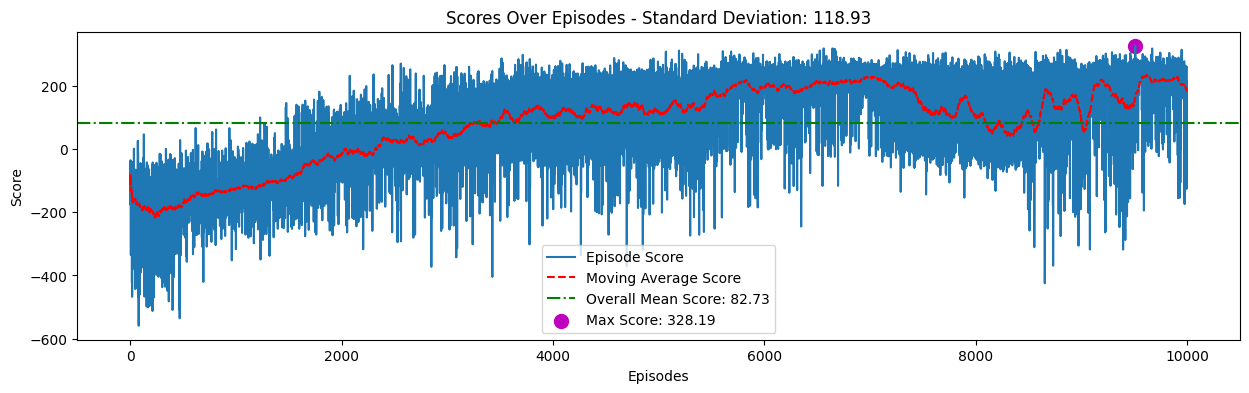

In [17]:
plot_score(score_hist, avg_score_hist, save_path='DQN_2_layer.png')

if str(device) == "cuda":
    torch.cuda.empty_cache()

In [13]:
if str(device) == "cuda":
    torch.cuda.empty_cache()

In [34]:
Qnet.

<function torch.nn.modules.module.Module.named_children(self) -> Iterator[Tuple[str, ForwardRef('Module')]]>

In [9]:
from pyvirtualdisplay import Display
from moviepy.editor import ImageSequenceClip

In [10]:
batch_size = 64
lr = 1e-3
episode = 10000
gamma = 0.999            # discount factor
memory_size = 10000     # max memory buffer size
learn_step = 5          # how often to learn
tau = 1e-4              # for soft update of target parameters
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
print(device)

cuda


In [11]:
loaded_agent = DQN(num_states, num_actions, batch_size, lr, gamma,
                   memory_size, learn_step, tau, device)

In [42]:
# 저장된 모델 불러오기
loaded_agent = DQN(num_states, num_actions, batch_size, lr, gamma,
                   memory_size, learn_step, tau, device)
model_path = "best_model.pth"

# 모델을 초기화하고 상태를 불러옴
loaded_agent.net_eval.load_state_dict(torch.load(model_path))
loaded_agent.net_eval.eval()  # 평가 모드로 설정

env = gym.make('LunarLander-v2') 

In [43]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

# Function to create a GIF from a list of frames
def create_gif(frames, filename, fps=60):
    imageio.mimsave(filename, frames, fps=fps)

# Function to add text to an image
def add_text_to_image(img, text, position=(20, 20), font_size=18, fill_color=(255, 255, 255)):
    img = Image.fromarray(img)
    font = ImageFont.truetype('arial.ttf', font_size)
    draw = ImageDraw.Draw(img)
    draw.text(position, text, font=font, fill=fill_color)
    return np.array(img)

In [56]:
import gym
import torch
from PIL import Image, ImageDraw, ImageFont
import imageio
import numpy as np

# Add this function to your code
def add_text_to_image(img, text, position=(20, 20), font_size=18, fill_color=(255, 255, 255)):
    img = Image.fromarray(img)
    font = ImageFont.truetype('arial.ttf', font_size)
    draw = ImageDraw.Draw(img)
    draw.text(position, text, font=font, fill=fill_color)
    return np.array(img)

# Add this function to your code
def create_gif(frames, filename, path="gifs/", fps=60):
    if not frames:
        print("No frames to save. Rendering issue.")
        return

    if not os.path.exists(path):
        os.makedirs(path)

    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=fps)
    print("Done!")

# Parameters
num_episodes = 5
max_steps_per_episode = 500

# Generate GIF frames
# Generate GIF frames
# Generate GIF frames
gif_frames = []
for episode in range(num_episodes):
    state = env.reset()
    episode_score = 0

    for step in range(max_steps_per_episode):
        # Render the environment
        frame = env.render()
        if frame is not None:
            # Add score text to the frame
            frame_with_text = add_text_to_image(frame, f"Score: {episode_score:.2f}")

            # Append the frame to the list of frames
            gif_frames.append(frame_with_text)

            # Choose an action using the trained DQN model
            state_tensor = torch.FloatTensor(state)
            action = torch.argmax(model(state_tensor)).item()

            # Take the chosen action
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            episode_score += reward

            # Break if the episode is done
            if done:
                break
        else:
            print("Rendering skipped. Trying again...")

# Close the environment
env.close()

# Create and save the GIF
create_gif(gif_frames, "lunarlander_animation.gif")


Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. Trying again...
Rendering skipped. T

In [51]:
state_tensor = torch.FloatTensor(state[0])
state_tensor

tensor([ 0.0020,  1.4194,  0.2018,  0.3763, -0.0023, -0.0457,  0.0000,  0.0000])